# KNN -  K Nearest Neighbors - Classification

To understand KNN for classification, we'll work with a simple dataset representing gene expression levels. Gene expression levels are calculated by the ratio between the expression of the target gene (i.e., the gene of interest) and the expression of one or more reference genes (often household genes). This dataset is synthetic and specifically designed to show some of the strengths and limitations of using KNN for Classification.


More info on gene expression: https://www.sciencedirect.com/topics/biochemistry-genetics-and-molecular-biology/gene-expression-level

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

In [2]:
df = pd.read_csv('..\data\gene_expression.csv')

In [3]:
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gene One        3000 non-null   float64
 1   Gene Two        3000 non-null   float64
 2   Cancer Present  3000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 70.4 KB


## Visualize

In [5]:
plt.style.use(['science','notebook','grid'])

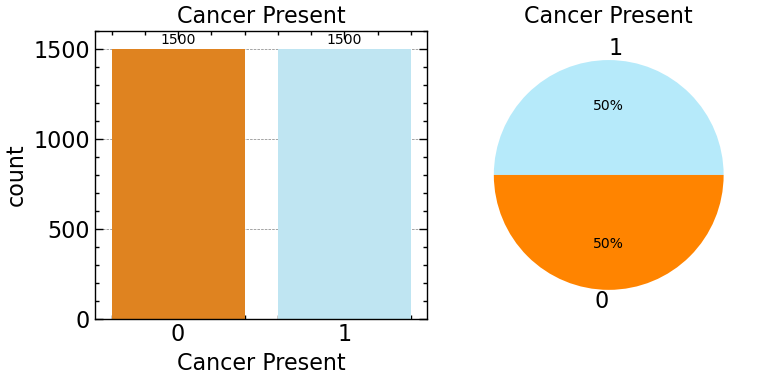

In [6]:
variable = 'Cancer Present'

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
ax = sns.countplot(x=variable, data = df, palette=['#FF8400','#B6EAFA'])

for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x() + p.get_width()/2, 
            y = height + 30, 
            s = '{:.0f}'.format(height), 
            ha = 'center'
            )
plt.ylim(0,1600) 
plt.title(variable)

# pie chart

plt.subplot(1,2,2)
counts = df['Cancer Present'].value_counts()
colors = sns.color_palette(['#B6EAFA','#FF8400'])
plt.pie(counts, labels= counts.index, autopct='%0.f%%', colors =colors)
plt.title(variable)

plt.tight_layout()
plt.show()

''

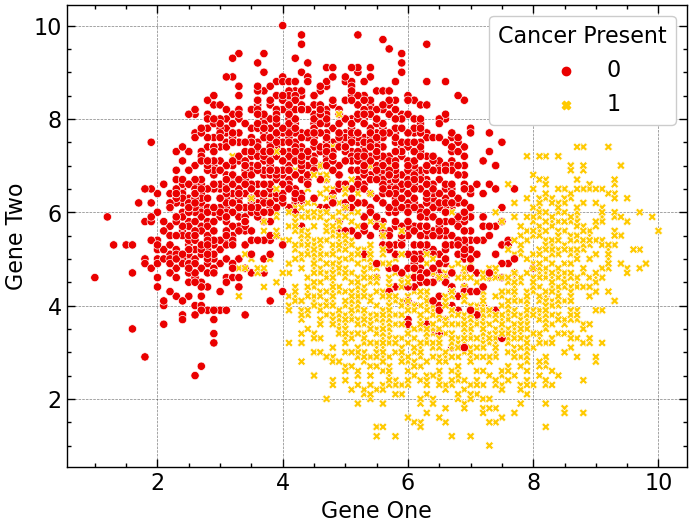

In [90]:
sns.scatterplot(x='Gene One', y='Gene Two', hue='Cancer Present', data= df, palette= 'hot', style = 'Cancer Present')
;

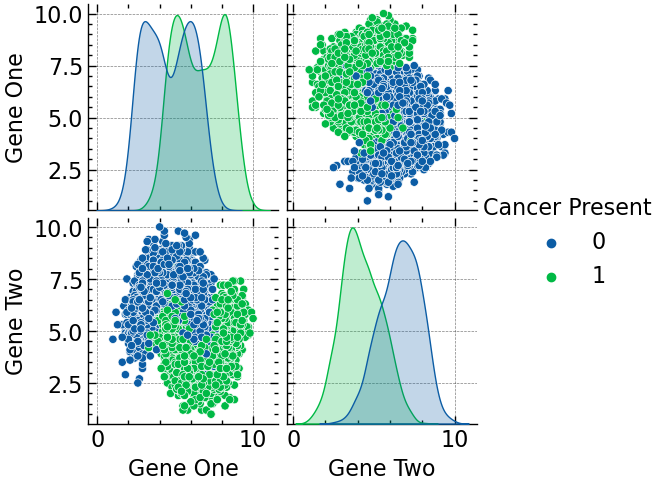

In [8]:
sns.pairplot(df, hue= 'Cancer Present');

In [9]:
import warnings
warnings.filterwarnings('ignore')

## Training | Test Split Data and Scale Data

In [10]:
X = df.drop('Cancer Present', axis= 1)
y = df['Cancer Present']

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
scaler = StandardScaler()

In [15]:
scaler_X_train = scaler.fit_transform(X_train)
scaler_X_test = scaler.transform(X_test)

In [16]:
# model
from sklearn.neighbors import KNeighborsClassifier

In [17]:
help(KNeighborsClassifier)

Help on class KNeighborsClassifier in module sklearn.neighbors._classification:

class KNeighborsClassifier(sklearn.neighbors._base.KNeighborsMixin, sklearn.base.ClassifierMixin, sklearn.neighbors._base.NeighborsBase)
 |  KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
 |  
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : {'uniform', 'distance'} or callable, default='uniform'
 |      Weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of their distance.
 |        in this case, closer neighbors of

In [18]:
knn_model = KNeighborsClassifier(n_neighbors = 1)

In [19]:
knn_model.fit(scaler_X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [20]:
predictions = knn_model.predict(scaler_X_test)

**Understand KNN and Choosing K-Value**

In [21]:
full_data = pd.concat([X_test, y_test],axis =1)

In [22]:
len(full_data)

900

In [23]:
full_data.columns

Index(['Gene One', 'Gene Two', 'Cancer Present'], dtype='object')

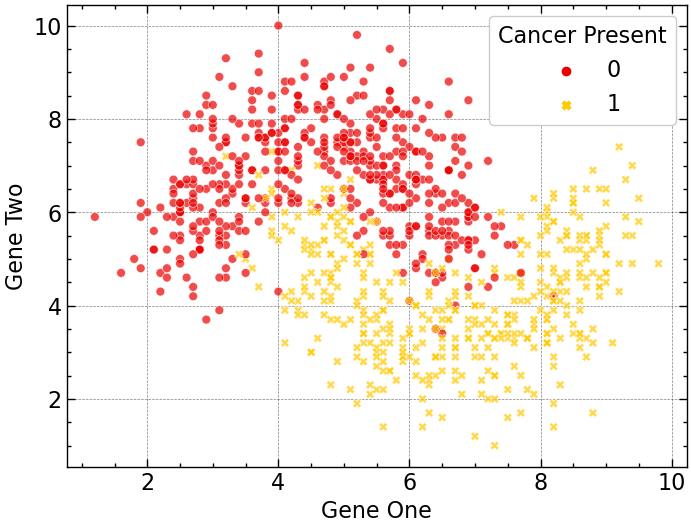

In [87]:
sns.scatterplot(x='Gene One', y= 'Gene Two', data= full_data, hue='Cancer Present', palette= 'hot', alpha=0.7, s=40, style='Cancer Present');

## Model Evaluation

In [25]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, ConfusionMatrixDisplay

In [26]:
confusion_matrix(y_test, predictions)

array([[426,  44],
       [ 45, 385]], dtype=int64)

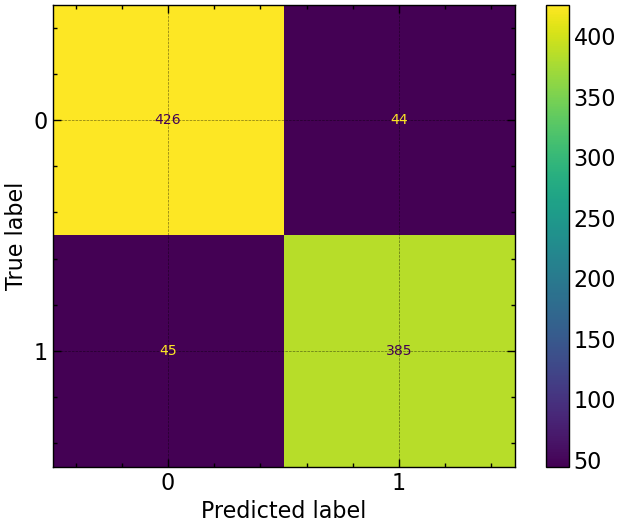

In [27]:
ConfusionMatrixDisplay.from_estimator(knn_model, scaler_X_test, y_test);

In [28]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       470
           1       0.90      0.90      0.90       430

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900



In [29]:
accuracy_score(y_test, predictions)

0.9011111111111111

## Elbow Method for Choosing Reasonable K Values

**NOTE: This uses the test set for the hyperparameter selection of K.**

In [30]:
test_error_rate = []

for k in range(1, 30):
    knn_model = KNeighborsClassifier(n_neighbors = k)
    knn_model.fit(scaler_X_train, y_train)
    
    preds = knn_model.predict(scaler_X_test)
    
    test_error = 1-accuracy_score(y_test, preds)
    test_error_rate.append(test_error)

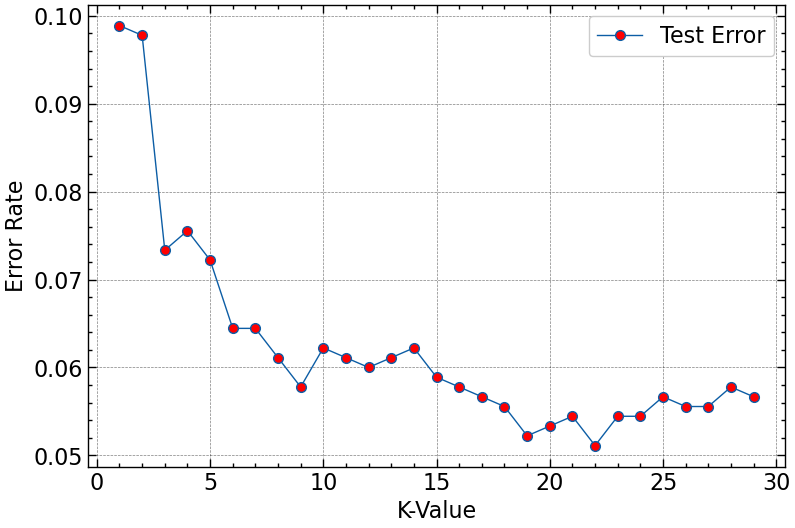

In [86]:
plt.figure(figsize= (9,6), dpi=100)
plt.plot(range(1, 30),test_error_rate, 'o-', lw=1, ms= 7,markerfacecolor='red',label='Test Error')
plt.xlabel('K-Value')
plt.ylabel('Error Rate')
plt.legend();

## Full Cross Validation Grid Search for K Value

### Creating a Pipeline to find K value

**Follow along very carefully here! We use very specific string codes AND variable names here so that everything matches up correctly. This is not a case where you can easily swap out variable names for whatever you want!**

We'll use a Pipeline object to set up a workflow of operations:

1. Scale Data
2. Create Model on Scaled Data

----
*How does the Scaler work inside a Pipeline with CV? Is scikit-learn "smart" enough to understand .fit() on train vs .transform() on train and test?**

**Yes! Scikit-Learn's pipeline is well suited for this! [Full Info in Documentation](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling) **

When you use the StandardScaler as a step inside a Pipeline then scikit-learn will internally do the job for you.

What happens can be discribed as follows:

* Step 0: The data are split into TRAINING data and TEST data according to the cv parameter that you specified in the GridSearchCV.
* Step 1: the scaler is fitted on the TRAINING data
* Step 2: the scaler transforms TRAINING data
* Step 3: the models are fitted/trained using the transformed TRAINING data
* Step 4: the scaler is used to transform the TEST data
* Step 5: the trained models predict using the transformed TEST data

----

In [32]:
scaler = StandardScaler()

In [33]:
knn = KNeighborsClassifier()

In [34]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [35]:
operations = [('scaler', scaler),('knn', knn)]

**Pipeline**

In [36]:
from sklearn.pipeline import Pipeline

In [37]:
pipe = Pipeline(operations)

**GridSearchCV**

In [38]:
k_values = list(range(1, 20))

In [39]:
param_grid = {'knn__n_neighbors': k_values}

In [40]:
from sklearn.model_selection import GridSearchCV

---
*Note: If your parameter grid is going inside a PipeLine, your parameter name needs to be specified in the following manner:**

* chosen_string_name + **two** underscores + parameter key name
* model_name + __ + parameter name
* knn_model + __ + n_neighbors
* knn_model__n_neighbors

[StackOverflow on this](https://stackoverflow.com/questions/41899132/invalid-parameter-for-sklearn-estimator-pipeline)

The reason we have to do this is because it let's scikit-learn know what operation in the pipeline these parameters are related to (otherwise it might think n_neighbors was a parameter in the scaler).

---

In [41]:
grid_model = GridSearchCV(pipe, param_grid, cv= 5, scoring='accuracy')

In [42]:
grid_model.fit(scaler_X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy')

In [43]:
grid_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=16))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=16),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 16,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [44]:
grid_model.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_knn__n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [45]:
len(k_values)

19

In [46]:
grid_model.cv_results_['mean_test_score']

array([0.90380952, 0.90761905, 0.92047619, 0.91285714, 0.92428571,
       0.92142857, 0.92761905, 0.9247619 , 0.9247619 , 0.92238095,
       0.92428571, 0.92571429, 0.92809524, 0.92857143, 0.92857143,
       0.93047619, 0.92857143, 0.92904762, 0.92809524])

In [47]:
len(grid_model.cv_results_['mean_test_score'])

19

## Final Model

In [48]:
scaler = StandardScaler()

In [49]:
knn16 = KNeighborsClassifier(n_neighbors = 16)

In [50]:
operations = [('scaler',scaler),('knn16', knn16)]

In [51]:
pipe = Pipeline(operations)

In [52]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn16', KNeighborsClassifier(n_neighbors=16))])

In [53]:
predictions = pipe.predict(X_test)

### Final Evaluation

In [54]:
confusion_matrix(y_test, predictions)

array([[449,  21],
       [ 31, 399]], dtype=int64)

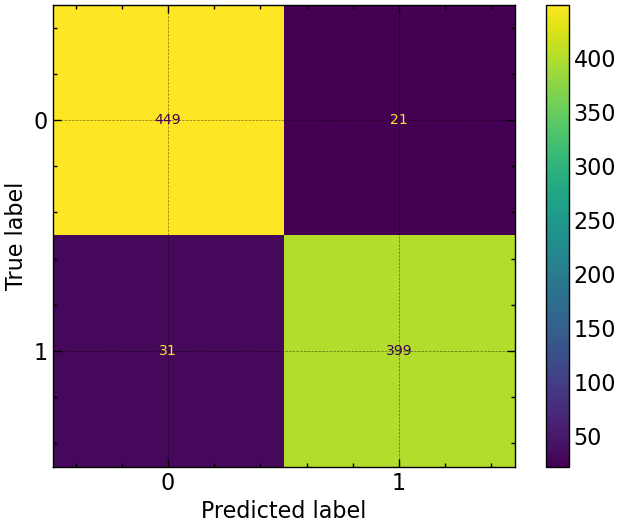

In [56]:
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test);

In [57]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       470
           1       0.95      0.93      0.94       430

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



In [58]:
accuracy_score(y_test, predictions)

0.9422222222222222

## Performance Curve

In [61]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

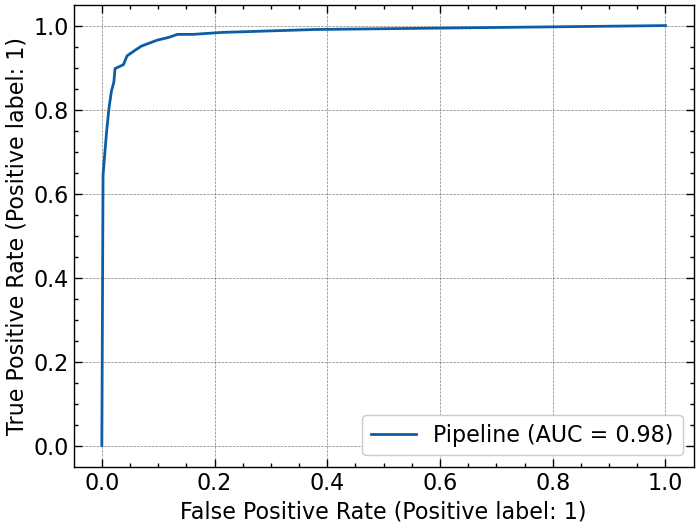

In [62]:
RocCurveDisplay.from_estimator(pipe, X_test, y_test);

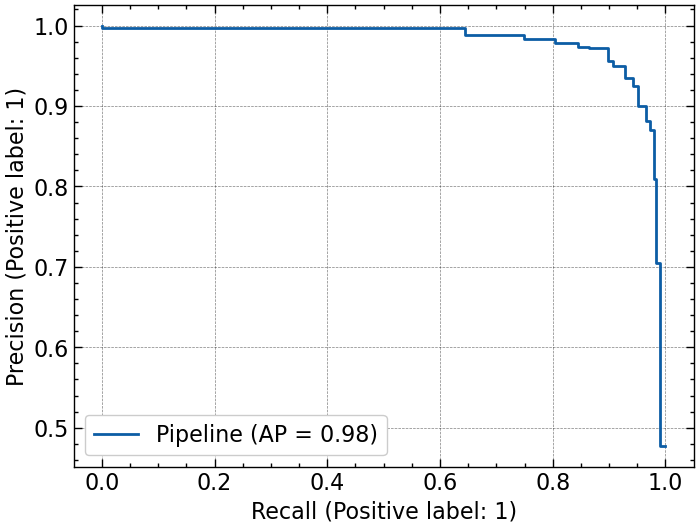

In [63]:
PrecisionRecallDisplay.from_estimator(pipe, X_test, y_test);

In [64]:
single_sample = X_test.iloc[40]

In [65]:
single_sample

Gene One    3.8
Gene Two    6.3
Name: 194, dtype: float64

In [66]:
pipe.predict(single_sample.values.reshape(1,-1))

array([0], dtype=int64)

In [67]:
pipe.predict_proba(single_sample.values.reshape(1,-1))

array([[0.9375, 0.0625]])

In [85]:
df.iloc[194]

Gene One          3.8
Gene Two          6.3
Cancer Present    0.0
Name: 194, dtype: float64